# Часть 1. 
**Обучение модели с нуля.**

In [2]:
#импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [2]:
#определение папки и пути к ней: train изображения
data_folder = Path("/content/drive/My Drive/train/")

In [3]:
#создание dataframe
df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')

In [4]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [4]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [5]:
#определяем размеры батча и изображения
BATCH_SIZE = 128
IMAGE_SHAPE  = 224

In [6]:
#препроцессинг изображений, приведение к размеру от 0 до 1
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
#train_generator должен перемешивать данные
train_generator_emotion = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",#режим классов "1D numpy array of integer labels"
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [9]:
#val_generator не должен перемешивать данные
val_generator_emotion = validation_image_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",#режим классов "1D numpy array of integer labels"
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [10]:
#определяем модель model_0
#Используем сверточные слои с размером фильтра (3,3) и relu активацией 
#После каждого сверточного слоя применяем MaxPool, уменьшающий размер в два раза
#Добавляем еще один conv+pool блок с 128 фильтрами
#Используем Flatten(), чтобы превратить последний тензор в вектор
#Добавляем полносвязный слой на 128 признаков
#Добавляем выходной слой с активацией softmax
model_0 = tf.keras.Sequential()
model_0.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)))
model_0.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model_0.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_0.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_0.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_0.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_0.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_0.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_0.add(tf.keras.layers.Flatten())
model_0.add(tf.keras.layers.Dense(128, activation='relu'))
model_0.add(tf.keras.layers.Dense(9, activation='softmax'))

In [11]:
#путь к папке, в которой будут сохраняться лучшие веса
#на момент начала работы обучение производилось в Colab, начиная с 5 части - в Jupyter (среда "tensorflow")
#соответственно, в данном случае веса сохранялись на Google диске, а в последствии - на компьютере
path = Path("drive/MyDrive/model_0_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [15]:
cpt_path

'drive/MyDrive/model_0_emotion/checkpoint_best.h5'

In [11]:
#компилляция модели и её вывод
model_0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [12]:
#в чек-поинтах следим за val_accuracy, так как наша задача максимизировать этот показатель
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [18]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_0 = model_0.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 5947s 245s/step - loss: 2.1989 - accuracy: 0.1391 - val_loss: 2.1690 - val_accuracy: 0.1352

Epoch 00001: val_accuracy improved from -inf to 0.13516, saving model to drive/MyDrive/model_0_emotion/checkpoint_best.h5
Epoch 2/30
25/25 [==============================] - 1387s 56s/step - loss: 2.1761 - accuracy: 0.1398 - val_loss: 2.1667 - val_accuracy: 0.1398

Epoch 00002: val_accuracy improved from 0.13516 to 0.13976, saving model to drive/MyDrive/model_0_emotion/checkpoint_best.h5
Epoch 3/30
25/25 [==============================] - 1300s 52s/step - loss: 2.1561 - accuracy: 0.1394 - val_loss: 2.1661 - val_accuracy: 0.1387

Epoch 00003: val_accuracy did not improve from 0.13976
Epoch 4/30
25/25 [==============================] - 1144s 46s/step - loss: 2.1627 - accuracy: 0.1416 - val_loss: 2.1533 - val_accuracy: 0.1515

Epoch 00004: val_accuracy improved from 0.13976 to 0.15155, saving model to drive/MyDrive/model_0_emotion/checkpoint_best

In [13]:
#добавили еще 10 эпох, чтобы улучшить val_accuracy до уровня > 0.4
EPOCHS = 40
model_0_sec = load_model("drive/My Drive/model_0_emotion/checkpoint_best.h5")
history_0 = model_0_sec.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 30,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 31/40
25/25 [==============================] - 7453s 307s/step - loss: 1.5562 - accuracy: 0.4328 - val_loss: 1.5391 - val_accuracy: 0.4426

Epoch 00031: val_accuracy improved from -inf to 0.44256, saving model to drive/MyDrive/model_0_emotion/checkpoint_best.h5
Epoch 32/40
25/25 [==============================] - 1957s 78s/step - loss: 1.5049 - accuracy: 0.4525 - val_loss: 1.5432 - val_accuracy: 0.4459

Epoch 00032: val_accuracy improved from 0.44256 to 0.44585, saving model to drive/MyDrive/model_0_emotion/checkpoint_best.h5
Epoch 33/40
25/25 [==============================] - 1825s 73s/step - loss: 1.4785 - accuracy: 0.4619 - val_loss: 1.5360 - val_accuracy: 0.4450

Epoch 00033: val_accuracy did not improve from 0.44585
Epoch 34/40
25/25 [==============================] - 1735s 69s/step - loss: 1.4675 - accuracy: 0.4791 - val_loss: 1.5553 - val_accuracy: 0.4455

Epoch 00034: val_accuracy did not improve from 0.44585
Epoch 35/40
25/25 [==============================] - 1595s 64s

In [14]:
df_test = pd.read_csv("/content/drive/My Drive/sample_submission.csv", sep=',')

In [15]:
df_test.head()

,image_path,emotion
0,0.jpg,neutral
1,1.jpg,neutral
2,2.jpg,neutral
3,3.jpg,neutral
4,4.jpg,neutral


In [16]:
test_data_folder = Path("/content/drive/My Drive/test_kaggle/test_kaggle/")

In [17]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [18]:
test_generator_emotion = test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 1 classes.


In [22]:
model_emotion_0 = load_model("drive/My Drive/model_0_emotion/checkpoint_best.h5")
loss, acc = model_emotion_0.evaluate(val_generator_emotion)
if acc < 0.29880:
    print("Please, try harder!")
else:
    if acc >= 0.4:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

79/79 [==============================] - 312s 4s/step - loss: 1.5320 - accuracy: 0.4480
Well done!


In [27]:
predicted_classes_0 = model_emotion_0.predict_classes(test_generator_emotion)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
sample_validation_images, sample_validation_labels = next(val_generator_emotion)

In [23]:
predicted = model_emotion_0.predict_classes(sample_validation_images).flatten()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [24]:
def show_emotions(images, labels, predicted_labels=None):
    names = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

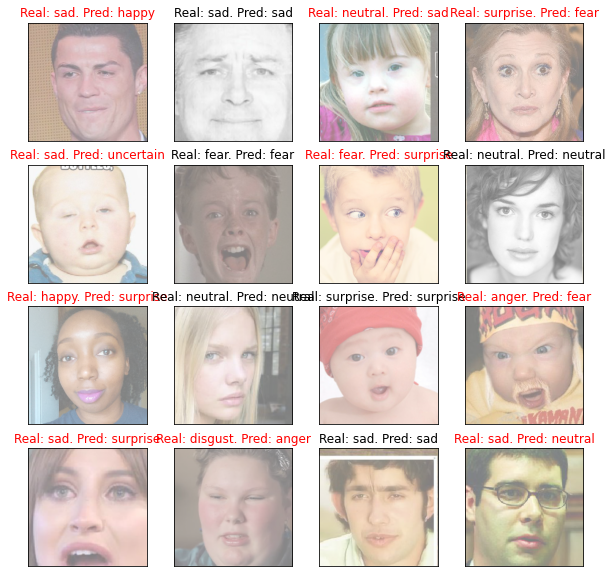

In [25]:
show_emotions(sample_validation_images, sample_validation_labels, predicted)

In [26]:
classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [28]:
classes_0 = []
for i in predicted_classes_0:
  classes_0.append(classes_mapping[i])

In [29]:
test_images = df_test['image_path'].to_list()

In [30]:
def write_to_submission_file(predictions, test_images, out_file='Submission.csv', columns=['image_path', 'emotion']):
    predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [31]:
write_to_submission_file(classes_0, test_images, out_file='Submission_0.csv', columns=['image_path', 'emotion'])

Обучение модели имело стабильный характер: val_accuracy увеличивалась от эпохи к эпохе, а val_loss постепенно снижался.
В результате обучения за 40 эпох была достигнута точность 0.44795 на валидационном датасете.

Submission на kaggle:
*public* 0.40960
*private* 0.40080

# Часть 2. 
**Обучение модели с применением аугментации.**

In [ ]:
#импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [ ]:
#определение папки и пути к ней: train изображения
data_folder = Path("/content/drive/My Drive/train/")

In [ ]:
#создание dataframe
df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')

In [ ]:
df.head()

In [ ]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [12]:
#препроцессинг изображений с применеием аугментации
# максимальный угол поворота 15
# смещение максимум на 20% ширины по горизонтали
# смещение максимум на 20% высоты по вертикали
# картинка будет увеличена или уменьшена не более чем на 10% 
# случайное отражение по горизонтали
# чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,  
      width_shift_range=0.20, 
      height_shift_range=0.20, 
      zoom_range=0.1, 
      horizontal_flip=True, 
      fill_mode="nearest", 
      )

In [13]:
#препроцессинг изображений, приведение к размеру от 0 до 1
test_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [14]:
BATCH_SIZE = 128
IMAGE_SHAPE = 224

In [15]:
#train_generator должен перемешивать данные, а val_generator - не должен
train_generator_emotion_aug = image_gen_aug.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [16]:
val_generator_emotion = validation_image_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [17]:
#определяем модель model_1
#Используем сверточные слои с размером фильтра (3,3) и relu активацией 
#После каждого сверточного слоя применяем MaxPool, уменьшающий размер в два раза
#Добавляем еще один conv+pool блок с 128 фильтрами
#Используем Flatten(), чтобы превратить последний тензор в вектор
#Добавляем полносвязный слой на 128 признаков
#Добавляем выходной слой с активацией softmax
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model_1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(9, activation='softmax'))

In [18]:
#путь к папке, в которой будут сохраняться лучшие веса
path = Path("drive/MyDrive/model_1_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [19]:
#в чек-поинтах следим за val_accuracy, так как наша задача максимизировать этот показатель
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [20]:
#компилляция модели и её вывод
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

In [ ]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_1 = model_1.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 9416s 388s/step - loss: 2.1964 - accuracy: 0.1359 - val_loss: 2.1621 - val_accuracy: 0.1438

Epoch 00001: val_accuracy improved from -inf to 0.14376, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 2/30
25/25 [==============================] - 2143s 86s/step - loss: 2.1563 - accuracy: 0.1484 - val_loss: 2.1584 - val_accuracy: 0.1378

Epoch 00002: val_accuracy did not improve from 0.14376
Epoch 3/30
25/25 [==============================] - 1929s 77s/step - loss: 2.1576 - accuracy: 0.1508 - val_loss: 2.1626 - val_accuracy: 0.1300

Epoch 00003: val_accuracy did not improve from 0.14376
Epoch 4/30
25/25 [==============================] - 1751s 70s/step - loss: 2.1593 - accuracy: 0.1372 - val_loss: 2.1601 - val_accuracy: 0.1305

Epoch 00004: val_accuracy did not improve from 0.14376
Epoch 5/30
25/25 [==============================] - 1606s 64s/step - loss: 2.1607 - accuracy: 0.1250 - val_loss: 2.1571 - val_accuracy: 

In [ ]:
#30 эпох по 25 шагов в каждой
#обучение модели
model_1_sec = load_model("drive/My Drive/model_1_emotion/checkpoint_best.h5")
EPOCHS = 30
history_1 = model_1_sec.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 11,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 12/30
25/25 [==============================] - 6008s 247s/step - loss: 2.1434 - accuracy: 0.1731 - val_loss: 2.1345 - val_accuracy: 0.1762

Epoch 00012: val_accuracy improved from -inf to 0.17622, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 13/30
25/25 [==============================] - 1758s 70s/step - loss: 2.1358 - accuracy: 0.1683 - val_loss: 2.1220 - val_accuracy: 0.1813

Epoch 00013: val_accuracy improved from 0.17622 to 0.18132, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 14/30
25/25 [==============================] - 1618s 65s/step - loss: 2.1252 - accuracy: 0.1800 - val_loss: 2.1217 - val_accuracy: 0.1831

Epoch 00014: val_accuracy improved from 0.18132 to 0.18312, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 15/30
25/25 [==============================] - 1536s 62s/step - loss: 2.1242 - accuracy: 0.1819 - val_loss: 2.1087 - val_accuracy: 0.1959

Epoch 00015: val_accuracy improved from 0.18312

In [21]:
#30 эпох по 25 шагов в каждой
#обучение модели
model_1_third = load_model("drive/My Drive/model_1_emotion/checkpoint_best.h5")
EPOCHS = 30
history_1 = model_1_third.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 18,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 19/30
25/25 [==============================] - 5895s 243s/step - loss: 2.1101 - accuracy: 0.2013 - val_loss: 2.0957 - val_accuracy: 0.2002

Epoch 00019: val_accuracy improved from -inf to 0.20020, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 20/30
25/25 [==============================] - 1748s 70s/step - loss: 2.1238 - accuracy: 0.1872 - val_loss: 2.0883 - val_accuracy: 0.2067

Epoch 00020: val_accuracy improved from 0.20020 to 0.20669, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 21/30
25/25 [==============================] - 1669s 67s/step - loss: 2.1181 - accuracy: 0.1834 - val_loss: 2.0822 - val_accuracy: 0.2134

Epoch 00021: val_accuracy improved from 0.20669 to 0.21339, saving model to drive/MyDrive/model_1_emotion/checkpoint_best.h5
Epoch 22/30
25/25 [==============================] - 1550s 62s/step - loss: 2.1169 - accuracy: 0.1994 - val_loss: 2.0813 - val_accuracy: 0.2152

Epoch 00022: val_accuracy improved from 0.21339

В результате обучения за 30 эпох была достигнута точность 0.23147 на валидационном датасете. Применение аугментации к модели из части 1 не привело к улучшению качества.

# Часть 3.
**Использование модели, предобученной на датасете "ImageNet" (без fine tuning).**

In [2]:
#импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [3]:
#определение папки и пути к ней: train изображения
data_folder = Path("/content/drive/My Drive/train/")

In [4]:
#создание dataframe
df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')

In [5]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [6]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
BATCH_SIZE = 128
IMAGE_SHAPE = 224

In [8]:
#train_generator должен перемешивать данные, а val_generator -- не должен
train_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [9]:
val_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [10]:
# базовая модель - MobileNet
IMG_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
#сначала без fine tuning
base_model.trainable = False

In [12]:
path = Path("drive/MyDrive/model_2_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [32]:
cpt_path

'drive/MyDrive/model_2_emotion/checkpoint_best.h5'

In [13]:
#определяем модель model_2
model_2 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1024, input_shape=IMG_SIZE, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [14]:
#в чек-поинтах следим за val_accuracy, так как наша задача максимизировать этот показатель
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1024)        1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 512)         524800    
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 64)          8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 32)          2

In [ ]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_2 = model_2.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
25/25 [==============================] - 2102s 85s/step - loss: 2.1947 - accuracy: 0.1669 - val_loss: 2.4117 - val_accuracy: 0.1768

Epoch 00001: val_accuracy improved from -inf to 0.17682, saving model to drive/MyDrive/model_2_emotion/checkpoint_best.h5
Epoch 2/30
25/25 [==============================] - 1113s 45s/step - loss: 1.8960 - accuracy: 0.2933 - val_loss: 3.0953 - val_accuracy: 0.1713

Epoch 00002: val_accuracy did not improve from 0.17682
Epoch 3/30


In [ ]:
#30 эпох по 25 шагов в каждой
#обучение модели
model_2_sec = load_model("drive/My Drive/model_2_emotion/checkpoint_best.h5")
EPOCHS = 30
history_2 = model_2_sec.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 2,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 3/30
25/25 [==============================] - 6573s 271s/step - loss: 1.6829 - accuracy: 0.3903 - val_loss: 3.7434 - val_accuracy: 0.1744

Epoch 00003: val_accuracy improved from -inf to 0.17443, saving model to drive/MyDrive/model_2_emotion/checkpoint_best.h5
Epoch 4/30
25/25 [==============================] - 1550s 62s/step - loss: 1.6379 - accuracy: 0.4078 - val_loss: 2.4219 - val_accuracy: 0.2708

Epoch 00004: val_accuracy improved from 0.17443 to 0.27083, saving model to drive/MyDrive/model_2_emotion/checkpoint_best.h5
Epoch 5/30
25/25 [==============================] - 1401s 56s/step - loss: 1.6307 - accuracy: 0.4019 - val_loss: 2.0922 - val_accuracy: 0.2476

Epoch 00005: val_accuracy did not improve from 0.27083
Epoch 6/30
25/25 [==============================] - 1288s 51s/step - loss: 1.5515 - accuracy: 0.4491 - val_loss: 2.2887 - val_accuracy: 0.2715

Epoch 00006: val_accuracy improved from 0.27083 to 0.27153, saving model to drive/MyDrive/model_2_emotion/checkpoint_best

In [ ]:
#30 эпох по 25 шагов в каждой
#обучение модели
model_2_third = load_model("drive/My Drive/model_2_emotion/checkpoint_best.h5")
EPOCHS = 30
history_2 = model_2_third.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 15,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 16/30
25/25 [==============================] - ETA: 0s - loss: 1.4732 - accuracy: 0.4609  

В результате обучения за 30 эпох была достигнута точность 0.37343 на валидационном датасете. Использование модели, обученной на датасете "ImageNet" без fine tuning, не привело к получению уровня качества, превышающего результат, полученный в части 1.

# Часть 4.
**Использование модели, предобученной на датасете "ImageNet" (без fine tuning), с применением аугментации и LearningRateScheduler.**

In [ ]:
#импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [ ]:
#определение папки и пути к ней: train изображения
data_folder = Path("/content/drive/My Drive/train/")

In [ ]:
#создание dataframe
df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')

In [ ]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [ ]:
#train_generator должен перемешивать данные, а val_generator -- не должен
train_generator_emotion_aug = image_gen_aug.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
val_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [ ]:
# базовая модель - MobileNet
IMG_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#без fine tuning
base_model.trainable = False

In [ ]:
path = Path("drive/MyDrive/model_3_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [ ]:
cpt_path

'drive/MyDrive/model_3_emotion/checkpoint_best.h5'

In [ ]:
#определяем модель model_3
model_3 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1024, input_shape=IMG_SIZE, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(27, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
#до 10 эпохи lr=lr, далее - уменьшается на заданное число
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

In [ ]:
#к чек-поинтам добавляем условие LearningRateScheduler
checkpoint = [tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'), 
              tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [ ]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1024)        1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 512)         524800    
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 64)          8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 32)          2

In [ ]:
EPOCHS = 15
history_3 = model_3.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
25/25 [==============================] - 2922s 119s/step - loss: 2.1411 - accuracy: 0.1688 - val_loss: 2.1129 - val_accuracy: 0.2117

Epoch 00001: val_accuracy improved from -inf to 0.21169, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 2/15
25/25 [==============================] - 1786s 72s/step - loss: 2.0956 - accuracy: 0.1981 - val_loss: 2.0630 - val_accuracy: 0.2209

Epoch 00002: val_accuracy improved from 0.21169 to 0.22088, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 3/15
25/25 [==============================] - 1757s 71s/step - loss: 2.0585 - accuracy: 0.2131 - val_loss: 2.1752 - val_accuracy: 0.1813

Epoch 00003: val_accuracy did not improve from 0.22088
Epoch 4/15
25/25 [==============================] - 1664s 67s/step - loss: 2.0559 - accuracy: 0.2203 - val_loss: 2.0270 - val_accuracy: 0.2442

Epoch 00004: val_accuracy improved from 0.22088 to 0.24416, saving model to drive/MyDrive/model_3_emotion/checkpoint_best

In [ ]:
EPOCHS = 20
model_3_sec = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
history_2 = model_3_sec.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 15,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 16/20
25/25 [==============================] - 6420s 264s/step - loss: 1.8556 - accuracy: 0.3075 - val_loss: 1.9358 - val_accuracy: 0.2879

Epoch 00016: val_accuracy improved from -inf to 0.28791, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 17/20
25/25 [==============================] - 1927s 77s/step - loss: 1.8978 - accuracy: 0.2903 - val_loss: 1.9078 - val_accuracy: 0.2865

Epoch 00017: val_accuracy did not improve from 0.28791
Epoch 18/20
25/25 [==============================] - 1780s 72s/step - loss: 1.9109 - accuracy: 0.2828 - val_loss: 1.9970 - val_accuracy: 0.2707

Epoch 00018: val_accuracy did not improve from 0.28791
Epoch 19/20
25/25 [==============================] - 1682s 68s/step - loss: 1.8908 - accuracy: 0.2978 - val_loss: 1.9272 - val_accuracy: 0.2957

Epoch 00019: val_accuracy improved from 0.28791 to 0.29570, saving model to drive/MyDrive/model_3_emotion/checkpoint_best.h5
Epoch 20/20
25/25 [==============================] - 1569s 63s

In [ ]:
EPOCHS = 30
model_3_third = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
history_2 = model_3_third.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    initial_epoch = 28,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 29/30
25/25 [==============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.3266  

In [ ]:
df_test = pd.read_csv("/content/drive/My Drive/sample_submission.csv", sep=',')

In [ ]:
df_test.head()

,image_path,emotion
0,0.jpg,neutral
1,1.jpg,neutral
2,2.jpg,neutral
3,3.jpg,neutral
4,4.jpg,neutral


In [ ]:
test_data_folder = Path("/content/drive/My Drive/test_kaggle/test_kaggle/")

In [ ]:
test_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 1 classes.


In [ ]:
model_emotion_3 = load_model("drive/My Drive/model_3_emotion/checkpoint_best.h5")
loss, acc = model_emotion_3.evaluate(val_generator_emotion)
if acc < 0.29880:
    print("Please, try harder!")
else:
    if acc >= 0.4:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

79/79 [==============================] - 4694s 60s/step - loss: 1.8472 - accuracy: 0.3823
Very good! Can you improve accuracy?


In [ ]:
predicted_classes_3 = model_emotion_3.predict_classes(test_generator_emotion)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
len(predicted_classes_3)

5000

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator_emotion)

In [ ]:
predicted = model_emotion_3.predict_classes(sample_validation_images).flatten()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def show_emotions(images, labels, predicted_labels=None):
    names = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

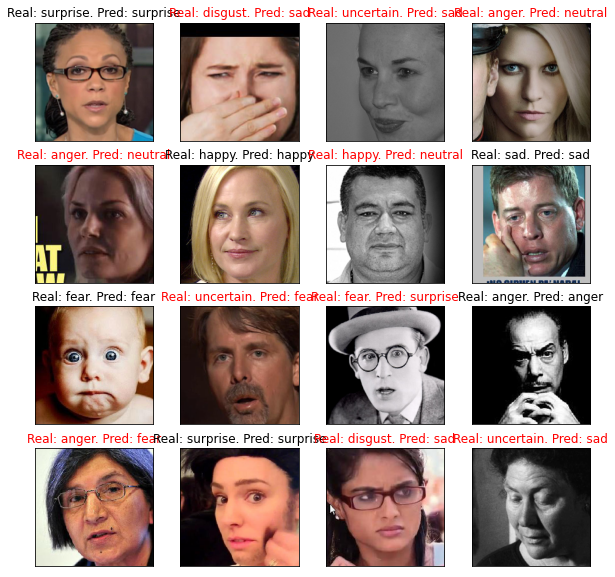

In [ ]:
show_emotions(sample_validation_images, sample_validation_labels, predicted)

In [ ]:
classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [ ]:
classes_3 = []
for i in predicted_classes_3:
  classes_3.append(classes_mapping[i])

In [ ]:
test_images = df_test['image_path'].to_list()

In [ ]:
def write_to_submission_file(predictions, test_images, out_file='Submission.csv', columns=['image_path', 'emotion']):
    predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [ ]:
write_to_submission_file(classes_3, test_images, out_file='Submission_3.csv', columns=['image_path', 'emotion'])

В результате обучения за 30 эпох была достигнута точность 0.3823 на валидационном датасете. Использование модели, обученной на датасете "ImageNet" без fine tuning, с применением аугментации и LearningRateScheduler, не привело к получению уровня качества, превышающего результат, полученный в части 1. Однако этот уровень выше, чем тот, что был получен в части 3.

Submission на kaggle:

*public* 0.31280
*private* 0.30680

# Часть 5.
**Использование модели, предобученной на датасете "ImageNet" (с fine tuning).**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [13]:
#определение папки и пути к ней: train изображения
data_folder = Path("train")

In [9]:
#создание dataframe
df = pd.read_csv("train.csv", sep=',')

In [10]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [11]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [6]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
BATCH_SIZE = 128
IMAGE_SHAPE = 224

In [14]:
#train_generator должен перемешивать данные, а val_generator -- не должен
train_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [15]:
val_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [16]:
# базовая модель - MobileNet
IMG_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  155


In [18]:
# все слои до -- заморозим
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [19]:
path = Path("model_4_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [31]:
#определяем модель model_4
#Используем сверточные слои с размером фильтра (7,7) и relu активацией
#Используем сверточные слои с размером фильтра (3,3) и relu активацией
#После каждого сверточного слоя применяйте MaxPool, уменьшающий размер в два раза
#Используем Flatten(), чтобы превратить последний тензор в вектор
#Добавляем полносвязный слой на 128 признаков
model_4 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
  
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=12, padding='same', 
                                 activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
  ])

In [24]:
#в чек-поинтах следим за val_accuracy, так как наша задача максимизировать этот показатель
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [32]:
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 64)          4014144   
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1, 1, 128)        

In [33]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_4 = model_4.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 2.1547 - accuracy: 0.1725  
Epoch 00001: val_accuracy improved from -inf to 0.14436, saving model to model_4_emotion\checkpoint_best.h5
25/25 [==============================] - 3419s 137s/step - loss: 2.1547 - accuracy: 0.1725 - val_loss: 3.9586 - val_accuracy: 0.1444
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 1.9520 - accuracy: 0.2684 
Epoch 00002: val_accuracy improved from 0.14436 to 0.18551, saving model to model_4_emotion\checkpoint_best.h5
25/25 [==============================] - 3448s 138s/step - loss: 1.9520 - accuracy: 0.2684 - val_loss: 2.8329 - val_accuracy: 0.1855
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 1.7759 - accuracy: 0.3500  
Epoch 00003: val_accuracy did not improve from 0.18551
25/25 [==============================] - 3458s 138s/step - loss: 1.7759 - accuracy: 0.3500 - val_

In [34]:
model_emotion_4 = load_model("model_4_emotion/checkpoint_best.h5")
loss, acc = model_emotion_4.evaluate(val_generator_emotion)
if acc < 0.29880:
    print("Please, try harder!")
else:
    if acc >= 0.4:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

79/79 [==============================] - 1929s 24s/step - loss: 2.0986 - accuracy: 0.3552
Very good! Can you improve accuracy?


In [35]:
df_test = pd.read_csv("sample_submission.csv", sep=',')

In [36]:
df_test.head()

,image_path,emotion
0,0.jpg,neutral
1,1.jpg,neutral
2,2.jpg,neutral
3,3.jpg,neutral
4,4.jpg,neutral


In [37]:
test_data_folder = Path("test_kaggle/test_kaggle")

In [38]:
test_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 1 classes.


In [39]:
predicted_classes_4 = model_emotion_4.predict_classes(test_generator_emotion)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [40]:
classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [41]:
classes_4 = []
for i in predicted_classes_4:
  classes_4.append(classes_mapping[i])

In [42]:
test_images = df_test['image_path'].to_list()

In [43]:
def write_to_submission_file(predictions, test_images, out_file='Submission.csv', columns=['image_path', 'emotion']):
    predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [44]:
write_to_submission_file(classes_4, test_images, out_file='Submission_4.csv', columns=['image_path', 'emotion'])

В результате обучения за 30 эпох была достигнута точность 0.3552 на валидационном датасете. Использование модели, обученной на датасете "ImageNet" с fine tuning, без применения аугментации и LearningRateScheduler, не привело к получению уровня качества, превышающего результат, полученный в части 1.  
Submission на kaggle:

*public* 0.36800 
*private* 0.36920

# Часть 6.
**Использование модели, предобученной на датасете "ImageNet" (с fine tuning), с применением аугментации и LearningRateScheduler. Fine tune at 100**

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing import image

In [46]:
#определение папки и пути к ней: train изображения
data_folder = Path("train")

In [47]:
#создание dataframe
df = pd.read_csv("train.csv", sep=',')

In [48]:
#разделение dataframe на тренировочную и валидационную части
df_train, df_val = train_test_split(df, test_size=0.2)

In [49]:
#препроцессинг изображений с применеием аугментации
# максимальный угол поворота
# смещение максимум на 20% ширины по горизонтали
# смещение максимум на 20% высоты по вертикали
# картинка будет увеличена или уменьшена не более чем на 10% 
# случайное отражение по горизонтали
# чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,  
      width_shift_range=0.20, 
      height_shift_range=0.20, 
      zoom_range=0.1, 
      horizontal_flip=True, 
      fill_mode="nearest", 
      )

In [51]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [52]:
BATCH_SIZE = 128
IMAGE_SHAPE = 224

In [50]:
#train_generator должен перемешивать данные, а val_generator -- не должен
train_generator_emotion_aug = image_gen_aug.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 40036 validated image filenames belonging to 9 classes.


In [53]:
val_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 10010 validated image filenames belonging to 9 classes.


In [54]:
# базовая модель - MobileNet
IMG_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

In [55]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  155


In [56]:
# все слои до -- заморозим
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [57]:
path = Path("model_5_emotion")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

In [58]:
#определяем модель model_5
#Используем сверточные слои с размером фильтра (7,7) и relu активацией
#Используем сверточные слои с размером фильтра (3,3) и relu активацией
#После каждого сверточного слоя применяйте MaxPool, уменьшающий размер в два раза
#Используем Flatten(), чтобы превратить последний тензор в вектор
#Добавляем полносвязный слой на 128 признаков
model_5 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
  
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
  ])

In [59]:
#до 10 эпохи lr=lr, далее - уменьшается на заданное число
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

In [60]:
#к чек-поинтам добавляем условие LearningRateScheduler
checkpoint = [tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'), 
              tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [61]:
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 64)          4014144   
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 1, 1, 128)        

In [62]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_5 = model_5.fit_generator(
    train_generator_emotion_aug,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 2.1590 - accuracy: 0.1478  
Epoch 00001: val_accuracy improved from -inf to 0.13307, saving model to model_5_emotion\checkpoint_best.h5
25/25 [==============================] - 3629s 145s/step - loss: 2.1590 - accuracy: 0.1478 - val_loss: 3.4982 - val_accuracy: 0.1331
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 1.9584 - accuracy: 0.2697 
Epoch 00002: val_accuracy did not improve from 0.13307
25/25 [==============================] - 3456s 138s/step - loss: 1.9584 - accuracy: 0.2697 - val_loss: 4.1243 - val_accuracy: 0.1265
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 1.8893 - accuracy: 0.3004  
Epoch 00003: val_accuracy improved from 0.13307 to 0.18382, saving model to model_5_emotion\checkpoint_best.h5
25/25 [==============================] - 3493s 140s/step - loss: 1.8893 - accuracy: 0.3004 - val_loss: 3.2546 - val_accuracy: 0.1838
Epoch 4/30
25/25 [======================

Epoch 28/30
25/25 [==============================] - ETA: 0s - loss: 1.4155 - accuracy: 0.4827 
Epoch 00028: val_accuracy did not improve from 0.38571
25/25 [==============================] - 3199s 128s/step - loss: 1.4155 - accuracy: 0.4827 - val_loss: 2.6540 - val_accuracy: 0.3405
Epoch 29/30
25/25 [==============================] - ETA: 0s - loss: 1.3828 - accuracy: 0.5066 
Epoch 00029: val_accuracy did not improve from 0.38571
25/25 [==============================] - 3223s 129s/step - loss: 1.3828 - accuracy: 0.5066 - val_loss: 2.6054 - val_accuracy: 0.3348
Epoch 30/30
25/25 [==============================] - ETA: 0s - loss: 1.4436 - accuracy: 0.4659 
Epoch 00030: val_accuracy did not improve from 0.38571
25/25 [==============================] - 3487s 139s/step - loss: 1.4436 - accuracy: 0.4659 - val_loss: 2.5820 - val_accuracy: 0.3311


In [68]:
model_emotion_5 = load_model("model_5_emotion/checkpoint_best.h5")
loss, acc = model_emotion_5.evaluate(val_generator_emotion)
if acc < 0.29880:
    print("Please, try harder!")
else:
    if acc >= 0.4:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

79/79 [==============================] - 2174s 28s/step - loss: 2.0301 - accuracy: 0.1645
Please, try harder!


In [64]:
df_test = pd.read_csv("sample_submission.csv", sep=',')

In [65]:
test_data_folder = Path("test_kaggle/test_kaggle")

In [66]:
test_generator_emotion = image_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_data_folder),
    x_col="image_path",
    y_col="emotion",
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 1 classes.


In [67]:
predicted_classes_5 = model_emotion_5.predict_classes(test_generator_emotion)

In [69]:
classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [70]:
classes_5 = []
for i in predicted_classes_5:
  classes_5.append(classes_mapping[i])

In [71]:
test_images = df_test['image_path'].to_list()

In [72]:
def write_to_submission_file(predictions, test_images, out_file='Submission.csv', columns=['image_path', 'emotion']):
    predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [73]:
write_to_submission_file(classes_5, test_images, out_file='Submission_5.csv', columns=['image_path', 'emotion'])

В результате обучения за 30 эпох была достигнута точность 0.38571 на валидационном датасете (evaluate(val_generator_emotion) при этом выдала результат 0.1645). Использование модели, обученной на датасете "ImageNet" с fine tuning, с применением аугментации и LearningRateScheduler, не привело к получению уровня качества, превышающего результат, полученный в части 1. Однако этот результат оказался выше того, что был получен в части 5, где аугментация не применялась.
Submission на kaggle:

*public* 0.38960 
*private* 0.37440

# Часть 7 (с оформлением по принципу ООП). 
**Использование модели, предобученной на датасете "ImageNet" (с fine tuning), с применением аугментации и LearningRateScheduler. Fine tune at 50**

In [25]:
class PREDICTION(tf.keras.Model):
    def __init__(self):
        
        """
        
        """

        super().__init__()
        
    def create_zero_model(IMAGE_SHAPE):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(9, activation='softmax'))
        return model
    
    def create_model_wo_finetuning(base_model, IMG_SIZE):
        base_model.trainable = False
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Dense(1024, input_shape=IMG_SIZE, activation='relu'),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(9, activation='softmax')
        ])
        return model
    
    
    def create_model_with_finetuning(base_model, IMG_SIZE, fine_tune_at):
        base_model.trainable = True
        print("Количество слоев в базовой модели: ", len(base_model.layers))
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
  
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=IMG_SIZE),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(9, activation='softmax')
        ])
        return model

    
    def prepare_data(data_folder, test_data_folder, train_image_generator, 
                     validation_image_generator, test_image_generator, IMAGE_SHAPE, BATCH_SIZE):
        df = pd.read_csv("train.csv", sep=',')
        #для работы в Colab df = pd.read_csv("/content/drive/My Drive/train.csv", sep=',')
        df_test = pd.read_csv("sample_submission.csv", sep=',')
        #для работы в Colab df_test = pd.read_csv("/content/drive/My Drive/sample_submission.csv", sep=',')
        df_train, df_val = train_test_split(df, test_size=0.2)
        
        train_generator_emotion = train_image_generator.flow_from_dataframe(
            dataframe=df_train,
            directory=str(data_folder),
            x_col="image_path",
            y_col="emotion",
            target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
            class_mode="sparse",
            batch_size=BATCH_SIZE,
            shuffle=True
        )
        val_generator_emotion = validation_image_generator.flow_from_dataframe(
            dataframe=df_val,
            directory=str(data_folder),
            x_col="image_path",
            y_col="emotion",
            target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
            class_mode="sparse",
            batch_size=BATCH_SIZE,
            shuffle=False
        )
        test_generator_emotion = test_image_generator.flow_from_dataframe(
            dataframe=df_test,
            directory=str(test_data_folder),
            x_col="image_path",
            y_col="emotion",
            target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
            class_mode="sparse",
            batch_size=BATCH_SIZE,
            shuffle=False
        )
        return train_generator_emotion, val_generator_emotion, test_generator_emotion
    
    def compile_model(model, folder):
        path = Path(folder)
        path.mkdir(exist_ok=True)
        cpt_filename = "checkpoint_best.h5"
        cpt_path =str(path / cpt_filename)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        print("cpt_path", cpt_path)
    
    def choose_checkpoint(cpt_path, scheduler=None):
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)
        if scheduler is not None:
            checkpoint = [tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'), 
              tf.keras.callbacks.LearningRateScheduler(scheduler)]
        else:
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        return checkpoint
    
    def evaluate_model(cpt_path, val_generator_emotion):
        model_emotion = load_model(cpt_path)
        loss, acc = model_emotion.evaluate(val_generator_emotion)
        if acc < 0.29880:
            print("Please, try harder!")
        else:
            if acc >= 0.4:
                print("Well done!")
            else:
                print("Very good! Can you improve accuracy?")
                
    def get_predictions(cpt_path, test_generator_emotion):
        model_emotion = load_model(cpt_path)
        print("Веса загружены")
        predicted_classes = model_emotion.predict_classes(test_generator_emotion)
        print("Получено ", len(predicted_classes), " предсказаний")
        classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        classes = []
        for i in predicted_classes:
            classes.append(classes_mapping[i])
        return classes
    
    def write_to_submission_file(predictions, out_file='Submission.csv', columns=['image_path', 'emotion']):
        df_test = pd.read_csv("sample_submission.csv", sep=',')
        test_images = df_test['image_path'].to_list()
        predicted_df = pd.DataFrame(list(zip(test_images, predictions)), columns=columns)
        predicted_df.to_csv(out_file, index=False)

In [36]:
#препроцессинг изображений с применеием аугментации
# максимальный угол поворота
# смещение максимум на 20% ширины по горизонтали
# смещение максимум на 20% высоты по вертикали
# картинка будет увеличена или уменьшена не более чем на 10% 
# случайное отражение по горизонтали
# чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,  
      width_shift_range=0.20, 
      height_shift_range=0.20, 
      zoom_range=0.1, 
      horizontal_flip=True, 
      fill_mode="nearest", 
      )

In [37]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [27]:
#определение папки и пути к ней: train изображения
data_folder = Path("train")

In [28]:
test_data_folder = Path("test_kaggle/test_kaggle")

In [49]:
BATCH_SIZE = 64
IMAGE_SHAPE = 224

In [50]:
train_generator_emotion, val_generator_emotion, test_generator_emotion = PREDICTION.prepare_data(data_folder, test_data_folder, image_gen_aug, image_gen, image_gen, IMAGE_SHAPE, BATCH_SIZE)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
Found 5000 validated image filenames belonging to 1 classes.


In [51]:
# базовая модель - MobileNet
IMG_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

In [52]:
model_6 = PREDICTION.create_model_with_finetuning(base_model, IMG_SIZE, fine_tune_at=50)

Количество слоев в базовой модели:  155


In [54]:
PREDICTION.compile_model(model_6, "model_6_emotion")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          4014144   
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 128)        

In [55]:
checkpoint = PREDICTION.choose_checkpoint("model_6_emotion\checkpoint_best.h5", scheduler=True)

In [56]:
#30 эпох по 25 шагов в каждой
#обучение модели
EPOCHS = 30
history_6 = model_6.fit_generator(
    train_generator_emotion,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator_emotion,
    callbacks=[checkpoint])

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 2.1763 - accuracy: 0.1425 
Epoch 00001: val_accuracy improved from -inf to 0.12707, saving model to model_6_emotion\checkpoint_best.h5
25/25 [==============================] - 2853s 114s/step - loss: 2.1763 - accuracy: 0.1425 - val_loss: 2.5147 - val_accuracy: 0.1271
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 2.1040 - accuracy: 0.2131 
Epoch 00002: val_accuracy improved from 0.12707 to 0.13536, saving model to model_6_emotion\checkpoint_best.h5
25/25 [==============================] - 2829s 113s/step - loss: 2.1040 - accuracy: 0.2131 - val_loss: 2.2183 - val_accuracy: 0.1354
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 2.0205 - accuracy: 0.2575 
Epoch 00003: val_accuracy improved from 0.13536 to 0.20569, saving model to model_6_emotion\checkpoint_best.h5
25/25 [==============================] - 2832s 113s/step - loss: 2.0205 - accuracy: 0.2575 - val_loss: 2.3734 - val_acc

Epoch 28/30
25/25 [==============================] - ETA: 0s - loss: 1.6051 - accuracy: 0.4144 
Epoch 00028: val_accuracy did not improve from 0.30150
25/25 [==============================] - 2923s 117s/step - loss: 1.6051 - accuracy: 0.4144 - val_loss: 2.7506 - val_accuracy: 0.2684
Epoch 29/30
25/25 [==============================] - ETA: 0s - loss: 1.6209 - accuracy: 0.3894 
Epoch 00029: val_accuracy improved from 0.30150 to 0.32418, saving model to model_6_emotion\checkpoint_best.h5
25/25 [==============================] - 2909s 116s/step - loss: 1.6209 - accuracy: 0.3894 - val_loss: 2.1222 - val_accuracy: 0.3242
Epoch 30/30
25/25 [==============================] - ETA: 0s - loss: 1.5727 - accuracy: 0.4169 
Epoch 00030: val_accuracy did not improve from 0.32418
25/25 [==============================] - 2921s 117s/step - loss: 1.5727 - accuracy: 0.4169 - val_loss: 2.2374 - val_accuracy: 0.3145


In [57]:
PREDICTION.evaluate_model("model_6_emotion\checkpoint_best.h5", val_generator_emotion)

157/157 [==============================] - 1892s 12s/step - loss: 2.1222 - accuracy: 0.2106
Please, try harder!


In [58]:
classes_6 = PREDICTION.get_predictions("model_6_emotion\checkpoint_best.h5", test_generator_emotion)

Веса загружены
Получено  5000  предсказаний


In [59]:
PREDICTION.write_to_submission_file(classes_6, out_file='Submission_6.csv', columns=['image_path', 'emotion'])

В результате обучения за 30 эпох была достигнута точность 0.32418 на валидационном датасете (evaluate(val_generator_emotion) при этом выдала результат 0.2106). Использование модели, обученной на датасете "ImageNet" с fine tuning, с применением аугментации и LearningRateScheduler при fine_tune_at=50, не привело к получению уровня качества, превышающего результат, полученный в части 1. Также этот результат оказался ниже того, что был получен в части 6, где был fine_tune_at=100. 
Submission на kaggle:

*public* 0.30600
*private* 0.31879

# Часть 8.
**Скрипт, который будет работать с веб-камерами и выводить на экран текущую эмоцию.**

Ноутбук должен быть открыт в среде tensorflow. Если её еще нет, то настроить среду можно в Anaconda Navigator следующим способом: 
-зайти в "Environment", 
-нажать "Create", 
-дать имя среде, например, "tensorflow", 
-нажать "Apply", 
-справа выбрать опцию "Not installed", подождать несколько минут, пока подгрузятся директории с названиями, содержащими "tensorflow", 
-выбрать "tensorflow ",
-перейти в "Home", 
-в блоке "Jupyter" нажать на "Install" и установить Jupyter notebook.

Для работы камеры требуется запускать ноутбук локально, у себя на компьютере

In [3]:
!pip install wget

  Using cached wget-3.2.zip (10 kB)
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=75b29a2db0dbbd1fa73fd4a7d31766c2ef15531847a23abbe116f39f489240fd
  Stored in directory: c:\users\baba_\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
#pip install opencv-python
import cv2
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [6]:
wget.download('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml')

100% [............................................................................] 930127 / 930127

'haarcascade_frontalface_default (1).xml'

In [4]:
class PREDICT_EMOTION(tf.keras.Model):
    def __init__(input_path):
        
        """
        input_path -- путь для загрузки весов модели
        """

        model = load_model(input_path)
        return model
    
    def predict_emotion(model, saving_output_path, loading_path, image_shape):
        cam = cv2.VideoCapture(0)
        if not cam.isOpened():
            print("Не удалось открыть камеру")
        else:
            print("Камера запущена")
        
        ret, frame = cam.read()
        if ret == True:
            plt.imshow(frame)
        bgr_image = frame
        bgr_image = cv2.resize(bgr_image, (image_shape, image_shape))
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        grayscale_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
#saving_output_path и loading_path важно разделить, так как flow_from_directory (ниже) будет считывать фотографии
#из папки более высокого уровня, пример:
#saving_output_path="saved_images/images", loading_path="saved_images", где loading_path является родительской директорией для  saving_output_path       
        face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = face_detector.detectMultiScale(grayscale_image, 1.3, 5)
        print("Найдено {} лицо/лиц".format(len(faces)))
        print("Массив faces: {}".format(faces))
        
        one_face = faces[0]
        x, y, w, h = one_face
        face_boundingbox_bgr = bgr_image[y:y + h, x:x + w]
        face_boundingbox_rgb = cv2.cvtColor(face_boundingbox_bgr, cv2.COLOR_BGR2RGB)

        
        path = saving_output_path
        cv2.imwrite(os.path.join(saving_output_path, 'loaded_image.jpg'), rgb_image)
        cv2.waitKey(0)
        
    #def read_frame():
        #while(True):
            #ret, frame = cam.read()
            #cv2.imshow("facial emotion recognition", frame)
            
            #if cv2.waitKey(1) & 0xFF == ord('q'):
                #break
                
        image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        loaded_image_generator_emotion = image_gen.flow_from_directory(
            directory = loading_path,
            target_size=(image_shape, image_shape))
        
        predicted_classes = model.predict_classes(loaded_image_generator_emotion)
        classes_mapping = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                           5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        
        path = saving_output_path
        for i in predicted_classes:
            emotion_text = str(classes_mapping[i])
   
            rgb_image = cv2.imread(os.path.join(saving_output_path, 'loaded_image.jpg'))
            rgb_image_with_boundingbox = deepcopy(rgb_image)
            rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (y, x), (y + h, x + w), (0,255,0), 3)
            rgb_image_with_boundingbox_and_text = deepcopy(rgb_image_with_boundingbox)
            rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox_and_text, emotion_text, (y, x - 10), 
                                                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            plt.figure(figsize=(15, 5))
            plt.imshow(rgb_image_with_boundingbox_and_text)
            plt.title("Predicted emotion:")
            plt.show()

In [5]:
IMAGE_SHAPE = 224

In [6]:
model_emotion = PREDICT_EMOTION.__init__("Submission_2_29.12.20/model_emotion/checkpoint_best.h5")

Камера запущена
Найдено 1 лицо/лиц
Массив faces: [[65 54 96 96]]
Found 1 images belonging to 1 classes.


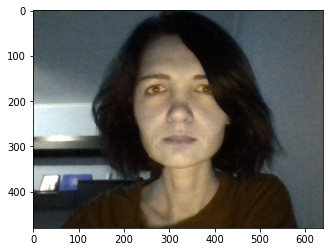

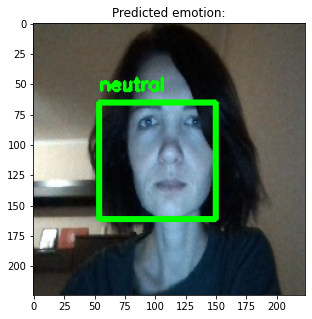

In [9]:
PREDICT_EMOTION.predict_emotion(model_emotion, saving_output_path="saved_images/images", loading_path="saved_images", image_shape=IMAGE_SHAPE)

# Выводы

Модель model_0, обученная с нуля без использования Imagenet, показала максимальный результат. Препроцессинг при этом был ImageDataGenerator(rescale=1./255).
Обучение модели имело стабильный характер: val_accuracy увеличивалась от эпохи к эпохе, а val_loss постепенно снижался. В результате обучения за 40 эпох была достигнута точность 0.44795 на валидационном датасете.

Submission на kaggle: public 0.40960 private 0.40080

Применение аугментации при обучении той же архитектуры (model_1) не привело к улучшению качества.

При использовании модели, предобученной на датасете "ImageNet" (без fine tuning), в результате обучения за 30 эпох была достигнута точность 0.37343 на валидационном датасете (model_2).

Использование модели, обученной на датасете "ImageNet" без fine tuning, с применением аугментации и LearningRateScheduler (model_3), не привело к получению уровня качества, превышающего результат, полученный в части 1 (для model_0). Однако этот уровень оказался выше, чем тот, что был получен в части 3, где аугментация не применялась.

Submission на kaggle:

public 0.31280 private 0.30680

Использование модели, обученной на датасете "ImageNet" с fine tuning (fine_tune_at=100), без применения аугментации и LearningRateScheduler (model_4), не привело к получению уровня качества, превышающего результат, полученный в части 1. Но этот результат оказался выше, чем тот, что был при обучении без fine tuning.
Submission на kaggle:

public 0.36800 private 0.36920

Использование модели, обученной на датасете "ImageNet" с fine tuning (fine_tune_at=100), с применением аугментации и LearningRateScheduler (model_5), не привело к получению уровня качества, превышающего результат, полученный в части 1. Однако этот результат оказался выше того, что был получен в части 5, где аугментация не применялась. 
Submission на kaggle:

public 0.38960 private 0.37440

Использование модели, обученной на датасете "ImageNet" с fine tuning (fine_tune_at=50), с применением аугментации и LearningRateScheduler (model_6), не привело к получению уровня качества, превышающего результат, полученный в части 1. Также этот результат оказался ниже того, что был получен в части 6, где был fine_tune_at=100. 
Submission на kaggle:

*public* 0.30600
*private* 0.31879

Итак, для получения наиболее высокого уровня качества больше всего подходят варианты из части 1 (model_0) и части 6 (model_5).